# 0. Setting up

## 0.1 Mounting GDrive

In [ ]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

DIR = r'/content/drive/Shareddrives/Materijali 2023 2024/6. semestar/Mašinsko učenje/Vežbe/Domaci 2/ml_d2_x_y_z.zip'

with zipfile.ZipFile(DIR, 'r') as zip_ref:
    zip_ref.extractall()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.2 Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,  LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC

# Ignore warnings
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

## 0.3 Loading Data

In [ ]:
DATA_DIR = 'ml_d2_x_y_z-2024/crop.csv'

df = pd.read_csv(DATA_DIR)

df.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


# 1. Feature Engineering

## 1.0 Splitting Features and Labels

In [ ]:
X = df.drop(columns=['Crop'])
y = df['Crop']

## 1.1 Class Distribution

In [ ]:
def plot_class_distribution(y):
  data = y.value_counts()
  plt.pie(data, labels=data.index, radius=1.2, rotatelabels=True)
  plt.show()

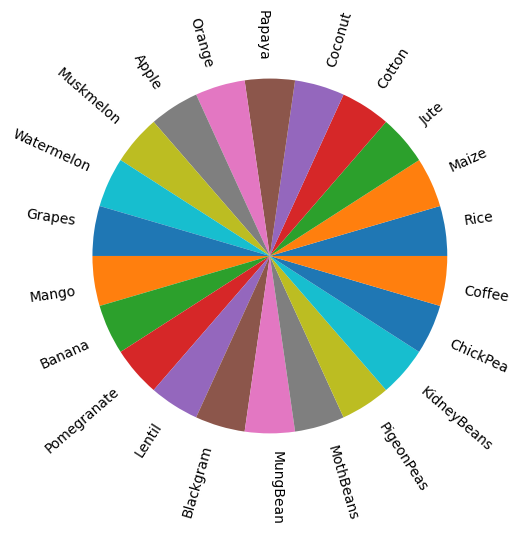

In [ ]:
plot_class_distribution(y)

## 1.2 Correlation

Plot Feature correlation heatmap

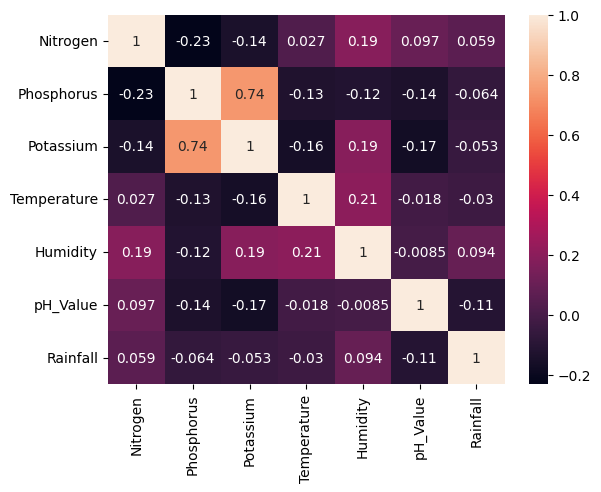

In [ ]:
corr = X.corr()
sns.heatmap(corr, annot=True)
plt.show()

## 1.3 Missing Values

In [ ]:
for col in df.columns:
  print(f'{col} nulls: {df[col].isnull().sum() } / {len(y)}')

Nitrogen nulls: 0 / 2200
Phosphorus nulls: 0 / 2200
Potassium nulls: 0 / 2200
Temperature nulls: 0 / 2200
Humidity nulls: 0 / 2200
pH_Value nulls: 0 / 2200
Rainfall nulls: 0 / 2200
Crop nulls: 0 / 2200


## 1.4 Skewness

In [ ]:
numeric_cols = X.select_dtypes(exclude=['object']).apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :numeric_cols})
skewness

,Skew
Potassium,2.373547
Phosphorus,1.010083
Rainfall,0.965098
Nitrogen,0.509374
pH_Value,0.283736
Temperature,0.184807
Humidity,-1.090963


## 1.5 Checking Normal Distribution

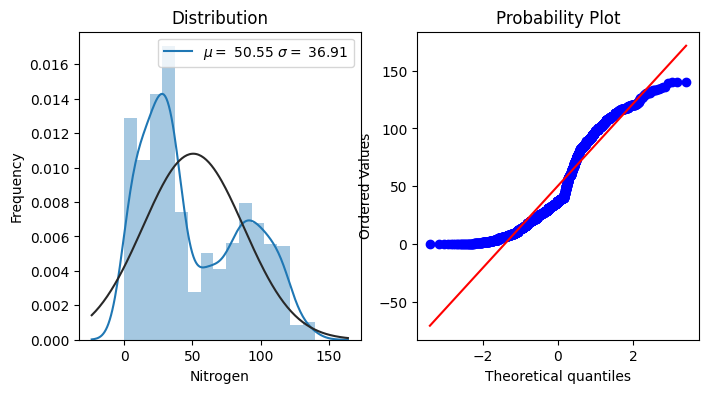

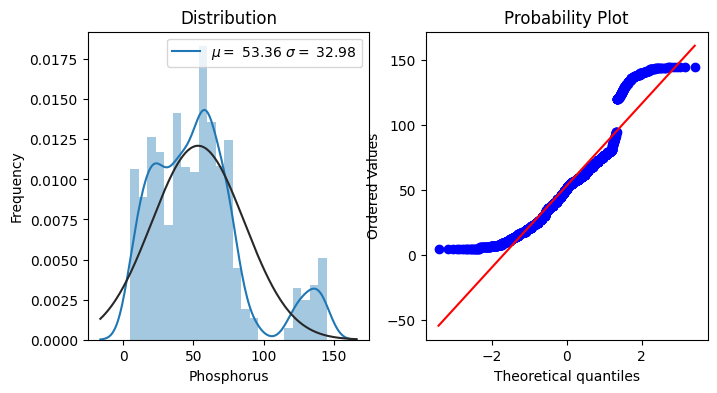

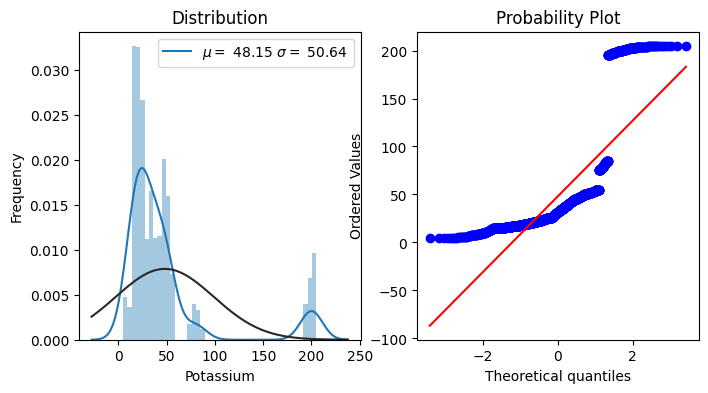

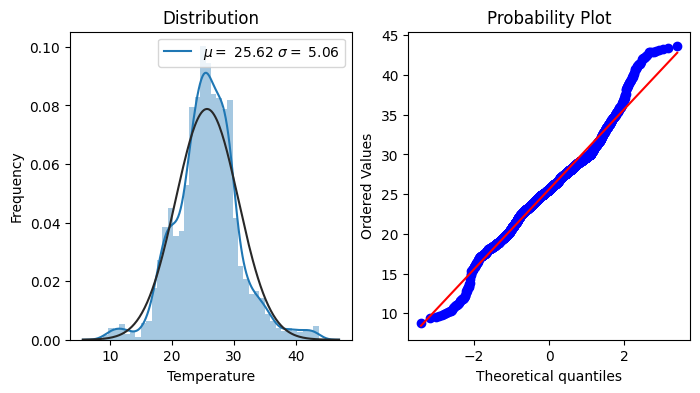

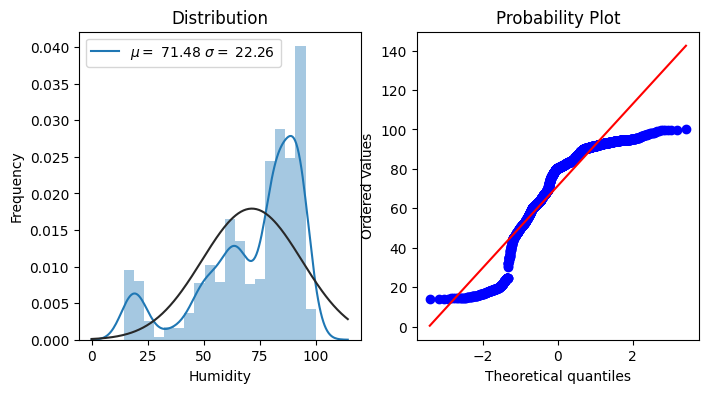

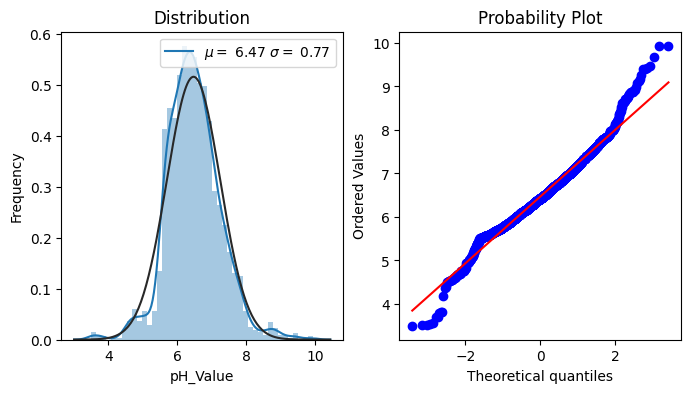

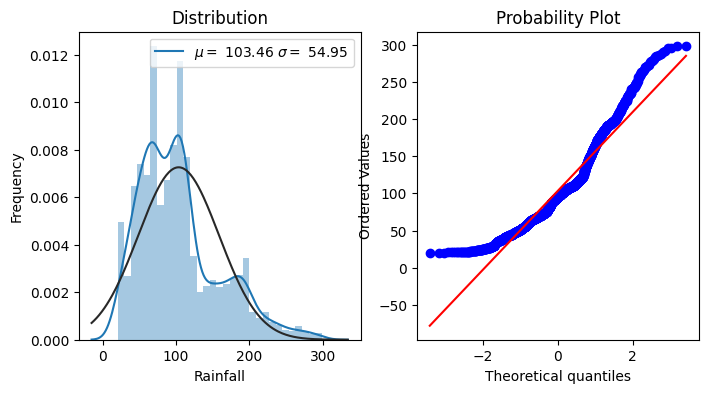

In [ ]:
def plot_normal_dist(df, feature):
  fig, ax = plt.subplots(1, 2, figsize=(8,4))

  (mean, std) = norm.fit(df[feature])

  sns.distplot(df[feature] , fit=norm, ax=ax[0])
  ax[0].legend([f'$\mu=$ {mean:.2f} $\sigma=$ {std:.2f}'], loc='best')
  ax[0].set_ylabel('Frequency')
  ax[0].set_title('Distribution')

  res = stats.probplot(df[feature], plot=plt)
  plt.show()
  return mean, std, res

for feature in X.columns:
  plot_normal_dist(X, feature)

## 1.6 Setting up transformations

Apply BoxCox/Log transformations to these sets of features

In [ ]:
boxcox_cols = ['Potassium', 'Phosphorus', 'Rainfall']
log_cols = []

Transformation Functions

In [ ]:
def log_transform(X):
  X = X.apply(lambda x: np.log1p(x))
  return X

def boxcox_transform(X, lmbda=0.3):
  X = X.apply(lambda x: boxcox1p(x, lmbda))
  return X

## 1.7 One-Hot-Encoding Labels

In [ ]:
y_onehot = pd.get_dummies(y)
y_onehot.shape

(2200, 22)

# 2. Bulding the Models

## 2.0 Cross-Validation Function

In [ ]:
def cross_validation(X, y,  models, y_onehot=[], models_onehot=[], model_names=None,
                     log_cols=[], boxcox_cols=[], k=5):

  if model_names is None:
    model_names = range(0, len(models))

  assert len(model_names) == len(models)

  res = {}

  if len(log_cols)>0:
    X[log_cols] = log_transform(X[log_cols])
  if len(boxcox_cols)>0:
    X[boxcox_cols] = boxcox_transform(X[boxcox_cols])

  kf = KFold(k, shuffle=True, random_state=42)

  for model, name in zip(models, model_names):

    res[name] = {}
    res[name]['train'] = {}
    res[name]['test'] = {}

    print(f'Testing model: {name}:')

    err_rate_train = np.empty(k)
    err_rate_test = np.empty(k)
    acc_train = np.empty(k)
    acc_test = np.empty(k)

    fold = 1
    for train_index, test_index in kf.split(X):


      if(model in models_onehot):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y_onehot.iloc[train_index], y_onehot.iloc[test_index]
      else:
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]


      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      acc_test[fold-1] = accuracy_score(y_test, y_pred)
      acc_train[fold-1] = accuracy_score(y_train, model.predict(X_train))

      print("Fold {:1.0f}".format(fold) + ": Accuracies on train {:0.3f}% and test {:0.3f}%"
      .format(acc_train[fold-1]*100, acc_test[fold-1]*100))
      fold += 1
    print("-"*50)

    train_std = np.std(acc_train)
    train_acc = np.mean(acc_train)

    test_std = np.std(acc_train)
    test_acc = np.mean(acc_test)

    print("Mean train accuracy: {:0.3f}%, std: {:0.3f}".format(train_acc*100, train_std))
    print("Mean test accuracy: {:0.3f}%, std: {:0.3f}".format(test_acc*100, test_std))

    res[name]['train']['std'] = train_std
    res[name]['train']['accuracy'] = train_acc

    res[name]['test']['std'] = test_std
    res[name]['test']['accuracy'] = test_acc



    print("\n\n")
  return res

## 2.1 Trying out Logistic Regression Classifiers

### 2.1.1 Finding the best Parameters

In [ ]:
#lr = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=10000, penalty='l1', solver='saga').fit(X, y)

#print('Optimal C = {0:.3f}'.format(lr.C_[0]))

# Output: Optimal C = 10.000

In [ ]:
#lr = LogisticRegressionCV(Cs=[10, 12, 15, 20], cv=5, max_iter=10000, penalty='l1', solver='saga').fit(X, y)

#print('Optimal C = {0:.3f}'.format(lr.C_[0]))

# Output: Optimal C = 10.000

In [ ]:
#lr = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 10], cv=5, max_iter=10000, penalty='l2', solver='saga').fit(X, y)

#print('Optimal C = {0:.3f}'.format(lr.C_[0]))

# Output: Optimal C = 10.000

In [ ]:
#lr = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 5, 10], cv=5, max_iter=1000, penalty='l2', solver='lbfgs').fit(X, y)

#print('Optimal C = {0:.3f}'.format(lr.C_[0]))

# Output: Optimal C = 10.000

### 2.1.2 Testing differet Logistic Regression models

In [ ]:
logreg_1 = LogisticRegression(solver='newton-cg', multi_class='multinomial', penalty='l2', max_iter=1000, random_state=42)
logreg_2 = LogisticRegression(solver='lbfgs', multi_class='multinomial', penalty=None, max_iter=400, random_state=42)
logreg_3 = LogisticRegression(solver='lbfgs', multi_class='multinomial', penalty='l2', C=10, max_iter=1000, random_state=42)
logreg_4 = LogisticRegression(solver='saga', multi_class='multinomial', penalty=None, max_iter=400, random_state=42)
logreg_5 = LogisticRegression(solver='saga', multi_class='multinomial', penalty='l1', C=10, max_iter=1000, random_state=42)



models = [logreg_1, logreg_2, logreg_3, logreg_4, logreg_5]
model_names = ['LogReg (Newton L2 1000)',
               'LogReg (Lbfgs NA 400)',
               'LogReg (Lbfgs L2 C=10 1000)',
               'LogReg (Saga NA 400)',
               'LogReg (Saga L1 C=10 1000)']


logreg_res = cross_validation(X, y, models, model_names=model_names, log_cols=log_cols,
                       boxcox_cols=boxcox_cols)

Testing model: LogReg (Newton L2 1000):
Fold 1: Accuracies on train 98.011% and test 96.136%
Fold 2: Accuracies on train 97.784% and test 96.591%
Fold 3: Accuracies on train 97.614% and test 97.727%
Fold 4: Accuracies on train 97.784% and test 97.500%
Fold 5: Accuracies on train 97.727% and test 97.500%
--------------------------------------------------
Mean train accuracy: 97.784%, std: 0.001
Mean test accuracy: 97.091%, std: 0.001



Testing model: LogReg (Lbfgs NA 400):
Fold 1: Accuracies on train 99.205% and test 97.727%
Fold 2: Accuracies on train 99.545% and test 97.955%
Fold 3: Accuracies on train 99.261% and test 98.636%
Fold 4: Accuracies on train 99.318% and test 98.636%
Fold 5: Accuracies on train 99.432% and test 97.727%
--------------------------------------------------
Mean train accuracy: 99.352%, std: 0.001
Mean test accuracy: 98.136%, std: 0.001



Testing model: LogReg (Lbfgs L2 C=10 1000):
Fold 1: Accuracies on train 98.920% and test 97.273%
Fold 2: Accuracies on tra

### 2.1.3 Plot model results

In [ ]:
def plot_model_results(res_dict, dataset='test'):
  accuracies = []
  stds = []

  for k in res_dict.keys():
    accuracies.append(res_dict[k][dataset]['accuracy'])
    stds.append(res_dict[k][dataset]['std'])

  plt.scatter(res_dict.keys(), accuracies, color='green')
  plt.errorbar(res_dict.keys(), accuracies, yerr=[stds, stds], fmt='o',
               elinewidth=20, ecolor='red',alpha=0.5, color='green')

  plt.ylabel('Accuracy +/- Standard Deviation')
  plt.xlabel('Model Name')
  plt.xticks(rotation=90)
  yline = (max(accuracies) - min(accuracies))/7
  plt.yticks(np.arange(min(accuracies), max(accuracies) + yline, yline))
  plt.grid(axis='y', linestyle='-')
  plt.show()

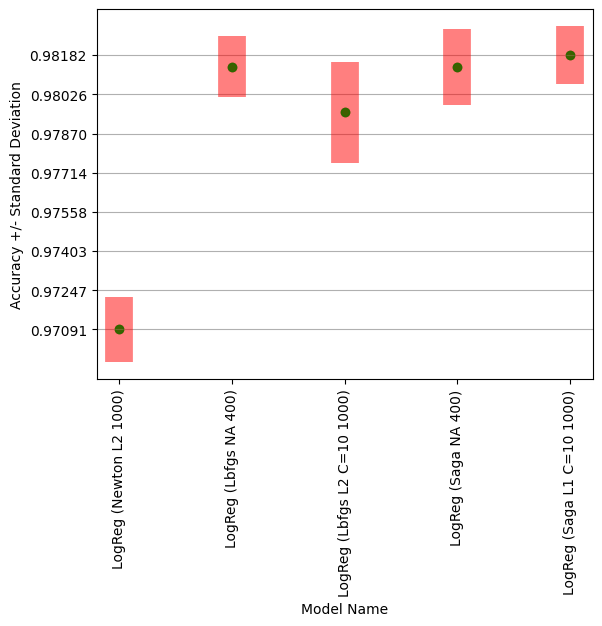

In [ ]:
plot_model_results(logreg_res)

In [ ]:
logreg_best = logreg_res['LogReg (Saga L1 C=10 1000)']
print(logreg_best)

{'train': {'std': 0.0011588680712710873, 'accuracy': 0.9915909090909091}, 'test': {'std': 0.0011588680712710873, 'accuracy': 0.9818181818181818}}


## 2.2 Trying out Decision Tree Classifiers

### 2.2.1 Testing different Decision Tree Classifier models

In [ ]:
tree_1 = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
tree_2 = DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)
tree_3 = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=42)
tree_4 = DecisionTreeClassifier(criterion='entropy', random_state=42)
tree_5 = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
tree_6 = DecisionTreeClassifier(criterion='gini', random_state=42)

models = [tree_1, tree_2, tree_3, tree_4, tree_5, tree_6]
model_names = ['Tree (Entropy Depth=4)',
               'Tree (Entropy Depth=7)',
               'Tree (Entropy Depth=10)',
               'Tree (Entropy)',
               'Tree (Gini Depth=10)',
               'Tree (Gini)']


tree_res = cross_validation(X, y, models, model_names=model_names,
                            log_cols=log_cols, boxcox_cols=boxcox_cols)

Testing model: Tree (Entropy Depth=4):
Fold 1: Accuracies on train 73.068% and test 68.409%
Fold 2: Accuracies on train 72.784% and test 69.318%
Fold 3: Accuracies on train 68.352% and test 64.773%
Fold 4: Accuracies on train 68.125% and test 66.818%
Fold 5: Accuracies on train 68.409% and test 66.364%
--------------------------------------------------
Mean train accuracy: 70.148%, std: 0.023
Mean test accuracy: 67.136%, std: 0.023



Testing model: Tree (Entropy Depth=7):
Fold 1: Accuracies on train 99.489% and test 98.182%
Fold 2: Accuracies on train 99.432% and test 97.727%
Fold 3: Accuracies on train 98.920% and test 97.045%
Fold 4: Accuracies on train 98.864% and test 98.636%
Fold 5: Accuracies on train 99.205% and test 98.182%
--------------------------------------------------
Mean train accuracy: 99.182%, std: 0.003
Mean test accuracy: 97.955%, std: 0.003



Testing model: Tree (Entropy Depth=10):
Fold 1: Accuracies on train 99.943% and test 97.955%
Fold 2: Accuracies on train 9

### 2.2.1 Plot the results

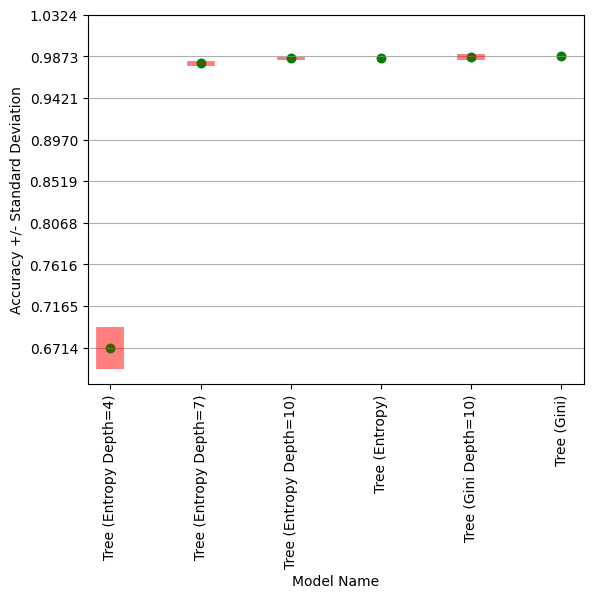

In [ ]:
plot_model_results(tree_res)

In [ ]:
tree_best = tree_res['Tree (Gini)']
tree_best

{'train': {'std': 0.0, 'accuracy': 1.0},
 'test': {'std': 0.0, 'accuracy': 0.9872727272727271}}

## 2.3 Trying out the other Classifiers

### 2.3.1 Testing Naive Bayes and Support Vecor Classifer models

In [ ]:
nb = GaussianNB()
svc_1 = LinearSVC(random_state=42)
svc_2= SVC(kernel='rbf', random_state=42)
svc_3 = SVC(kernel='poly', degree=2, coef0=3, random_state=42)
svc_4 = SVC(kernel='poly', degree=3, coef0=5, random_state=42)
svc_5 = SVC(kernel='poly', degree=4, coef0=5, random_state=42)

models = [nb, svc_1, svc_2, svc_3, svc_4, svc_5]
model_names = ['NB (Gauss)',
               'SVC (Linear)',
               'SVC (Rbf)',
               'SVC (Poly deg=2 coef0=3)',
               'SVC (Poly deg=3 coef0=5)',
               'SVC (Poly deg=4 coef0=5)']


other_res = cross_validation(X, y, models, model_names=model_names, log_cols=log_cols,
                       boxcox_cols=boxcox_cols)

Testing model: NB (Gauss):
Fold 1: Accuracies on train 99.489% and test 99.318%
Fold 2: Accuracies on train 99.602% and test 99.091%
Fold 3: Accuracies on train 99.489% and test 99.545%
Fold 4: Accuracies on train 99.489% and test 99.545%
Fold 5: Accuracies on train 99.375% and test 99.773%
--------------------------------------------------
Mean train accuracy: 99.489%, std: 0.001
Mean test accuracy: 99.455%, std: 0.001



Testing model: SVC (Linear):
Fold 1: Accuracies on train 96.250% and test 94.318%
Fold 2: Accuracies on train 96.193% and test 93.864%
Fold 3: Accuracies on train 95.909% and test 97.045%
Fold 4: Accuracies on train 96.193% and test 96.364%
Fold 5: Accuracies on train 96.136% and test 94.545%
--------------------------------------------------
Mean train accuracy: 96.136%, std: 0.001
Mean test accuracy: 95.227%, std: 0.001



Testing model: SVC (Rbf):
Fold 1: Accuracies on train 98.920% and test 97.727%
Fold 2: Accuracies on train 98.750% and test 98.636%
Fold 3: Accu

### 2.3.2 Plot the results

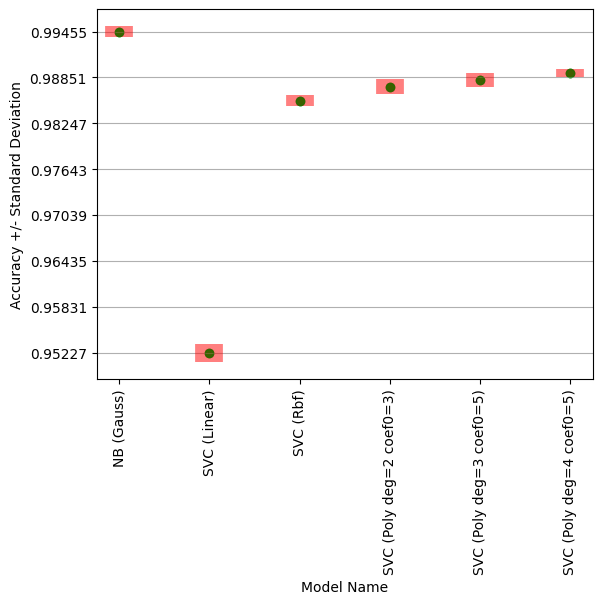

In [ ]:
plot_model_results(other_res)

In [ ]:
best_nb = other_res['NB (Gauss)']
best_svc = other_res['SVC (Poly deg=3 coef0=5)']
print(best_nb)
print(best_svc)

{'train': {'std': 0.0007186994682200644, 'accuracy': 0.9948863636363636}, 'test': {'std': 0.0007186994682200644, 'accuracy': 0.9945454545454545}}
{'train': {'std': 0.0009507500301523697, 'accuracy': 0.9943181818181819}, 'test': {'std': 0.0009507500301523697, 'accuracy': 0.9881818181818183}}


# 3. Discussion

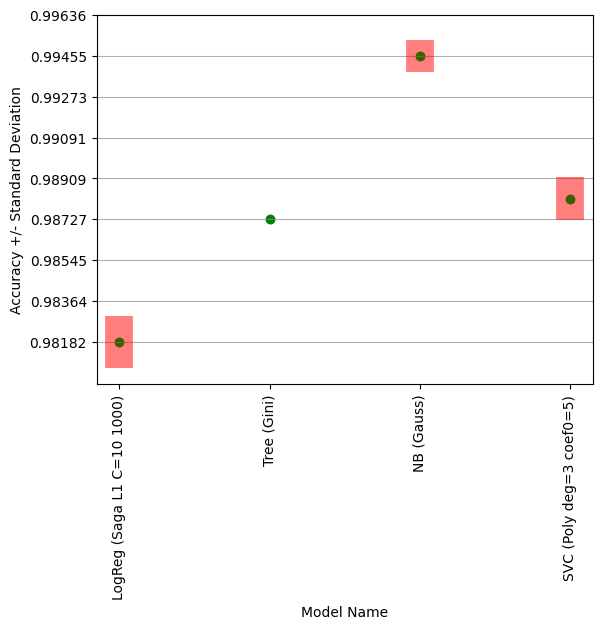

In [ ]:
best_models_res = {'LogReg (Saga L1 C=10 1000)': logreg_best,
                   'Tree (Gini)': tree_best,
                   'NB (Gauss)': best_nb,
                   'SVC (Poly deg=3 coef0=5)': best_svc}

plot_model_results(best_models_res)

In [ ]:
def test_models(X, y, models, model_names=None, log_cols=[], boxcox_cols=[], test_size=0.2):

  assert len(models) == len(model_names)

  if model_names is None:
    model_names = range(0, len(models))

  if len(log_cols)>0:
    X[log_cols] = log_transform(X[log_cols])
  if len(boxcox_cols)>0:
    X[boxcox_cols] = boxcox_transform(X[boxcox_cols])

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True, random_state=0)

  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  for model, name in zip(models, model_names):

    print(f'Testing {name}...')

    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_preds) * 100
    print(f'Accuracy: {accuracy:.2f}')
    print('Classification report:')
    print(classification_report(y_test, y_preds))

    cm = confusion_matrix(y_test, y_preds, labels=model.classes_)

    fig, ax = plt.subplots(figsize=(10, 10))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_)


    disp.plot(ax=ax)
    plt.xticks(rotation=90)
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    print('_'*100)
    print('\n')


Testing LogReg (Saga L1 C=10 1000)...
Accuracy: 98.18
Classification report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        18
      Banana       1.00      1.00      1.00        18
   Blackgram       1.00      1.00      1.00        22
    ChickPea       1.00      1.00      1.00        23
     Coconut       1.00      1.00      1.00        15
      Coffee       1.00      1.00      1.00        17
      Cotton       1.00      1.00      1.00        16
      Grapes       1.00      1.00      1.00        18
        Jute       0.87      0.95      0.91        21
 KidneyBeans       0.95      1.00      0.98        20
      Lentil       0.94      0.94      0.94        17
       Maize       1.00      1.00      1.00        18
       Mango       1.00      1.00      1.00        21
   MothBeans       0.96      0.92      0.94        25
    MungBean       1.00      1.00      1.00        17
   Muskmelon       1.00      1.00      1.00        23
    

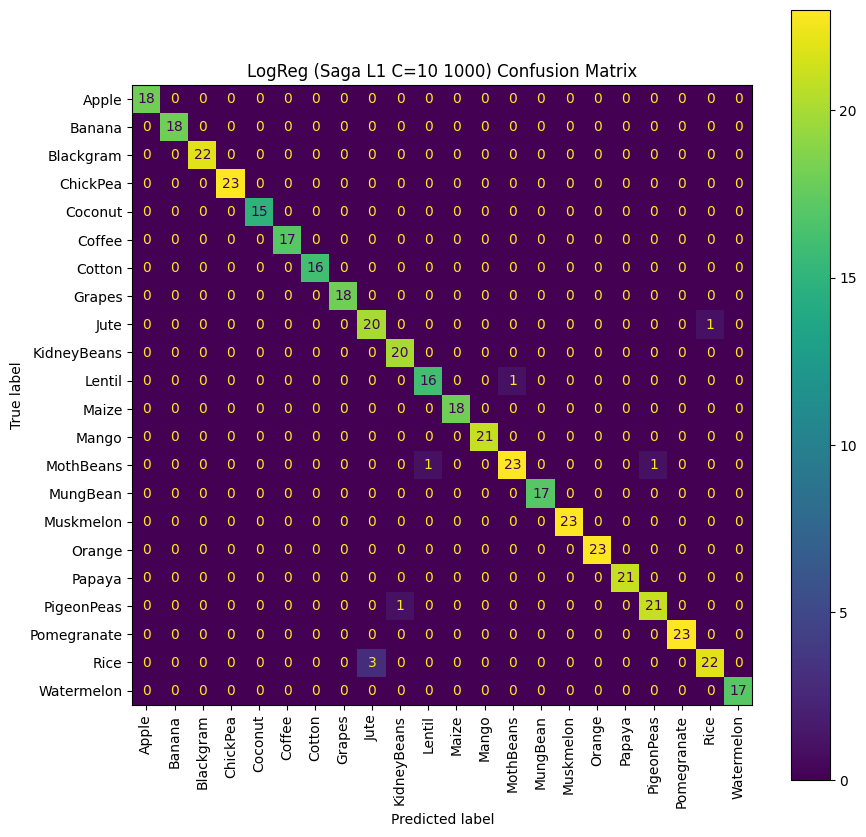

____________________________________________________________________________________________________


Testing Tree (Gini)...
Accuracy: 98.86
Classification report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        18
      Banana       1.00      1.00      1.00        18
   Blackgram       1.00      0.95      0.98        22
    ChickPea       0.92      1.00      0.96        23
     Coconut       1.00      1.00      1.00        15
      Coffee       1.00      1.00      1.00        17
      Cotton       1.00      1.00      1.00        16
      Grapes       1.00      1.00      1.00        18
        Jute       0.95      0.95      0.95        21
 KidneyBeans       1.00      0.90      0.95        20
      Lentil       1.00      1.00      1.00        17
       Maize       1.00      1.00      1.00        18
       Mango       1.00      1.00      1.00        21
   MothBeans       0.96      1.00      0.98        25
    MungBean       1.00 

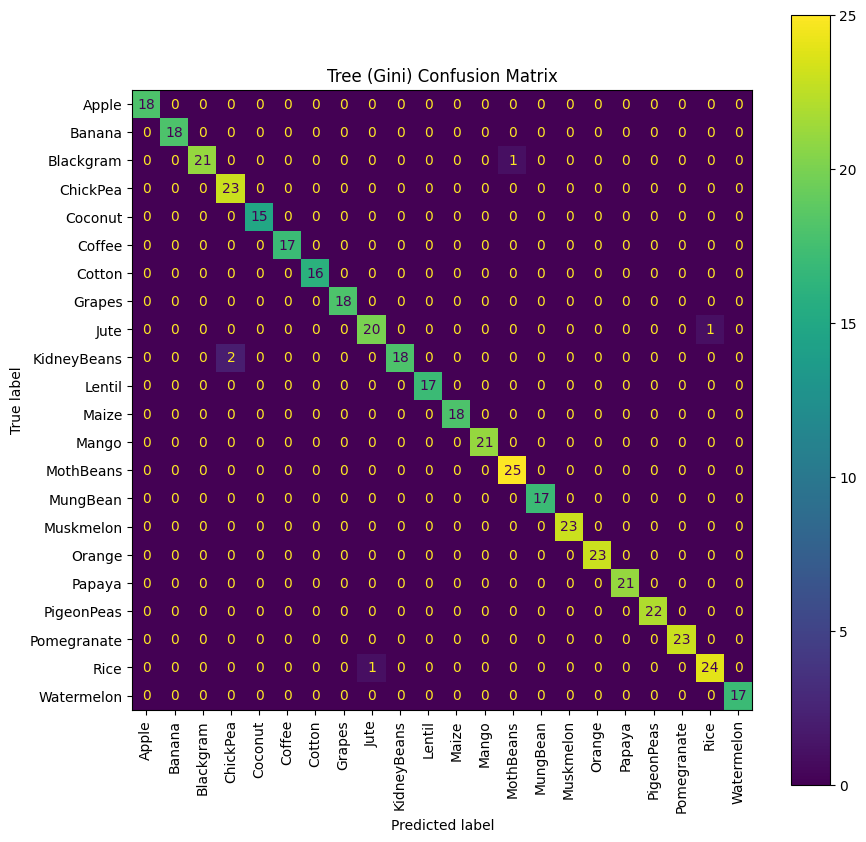

____________________________________________________________________________________________________


Testing NB (Gauss)...
Accuracy: 99.55
Classification report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        18
      Banana       1.00      1.00      1.00        18
   Blackgram       1.00      1.00      1.00        22
    ChickPea       1.00      1.00      1.00        23
     Coconut       1.00      1.00      1.00        15
      Coffee       1.00      1.00      1.00        17
      Cotton       1.00      1.00      1.00        16
      Grapes       1.00      1.00      1.00        18
        Jute       0.91      1.00      0.95        21
 KidneyBeans       1.00      1.00      1.00        20
      Lentil       1.00      1.00      1.00        17
       Maize       1.00      1.00      1.00        18
       Mango       1.00      1.00      1.00        21
   MothBeans       1.00      1.00      1.00        25
    MungBean       1.00  

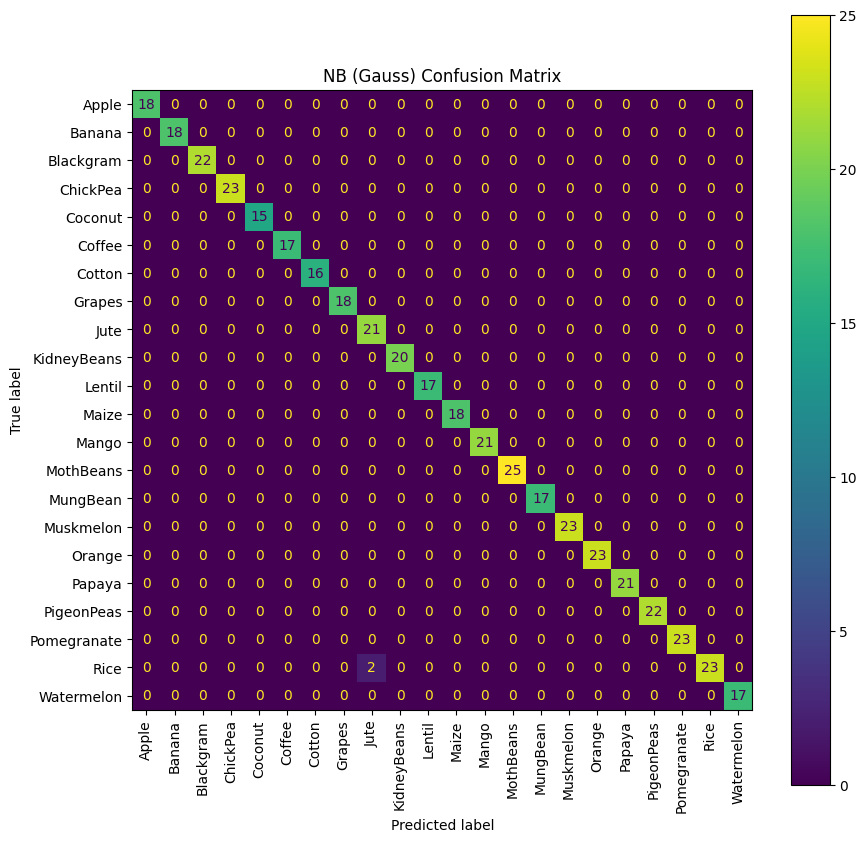

____________________________________________________________________________________________________


Testing SVC (Poly deg=3 coef0=5)...
Accuracy: 99.09
Classification report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        18
      Banana       1.00      1.00      1.00        18
   Blackgram       1.00      1.00      1.00        22
    ChickPea       1.00      1.00      1.00        23
     Coconut       1.00      1.00      1.00        15
      Coffee       1.00      1.00      1.00        17
      Cotton       1.00      0.94      0.97        16
      Grapes       1.00      1.00      1.00        18
        Jute       0.91      0.95      0.93        21
 KidneyBeans       1.00      1.00      1.00        20
      Lentil       1.00      1.00      1.00        17
       Maize       0.95      1.00      0.97        18
       Mango       1.00      1.00      1.00        21
   MothBeans       1.00      1.00      1.00        25
    MungBea

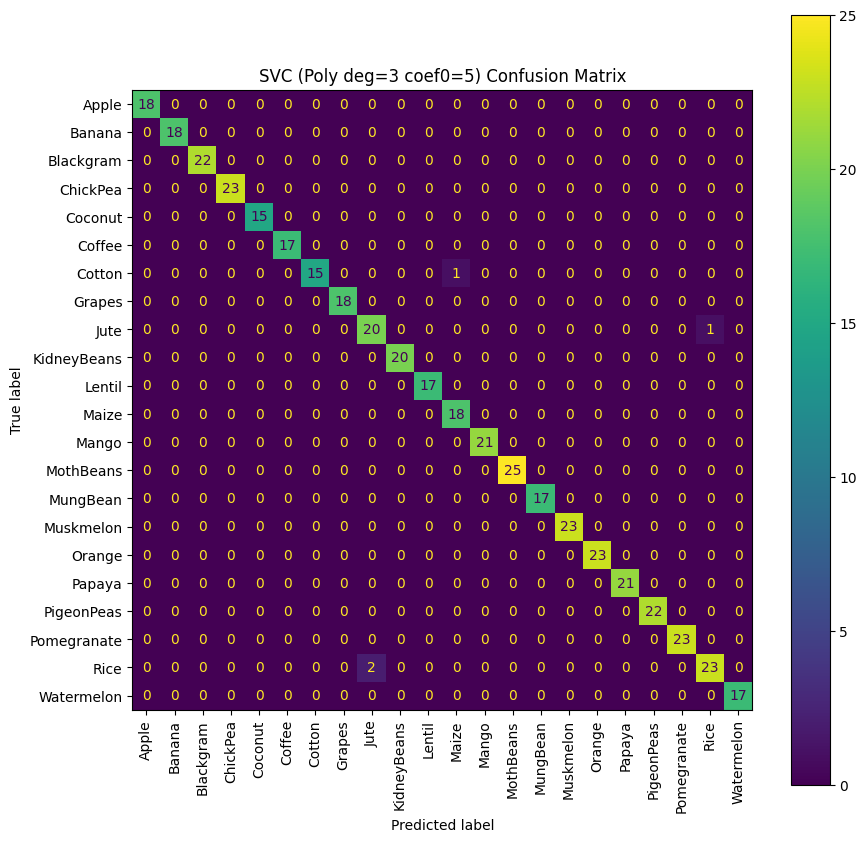

____________________________________________________________________________________________________




In [ ]:
best_models = [logreg_5, tree_6, nb, svc_4]
best_model_names = ['LogReg (Saga L1 C=10 1000)', 'Tree (Gini)', 'NB (Gauss)', 'SVC (Poly deg=3 coef0=5)']

test_models(X, y, best_models, best_model_names, log_cols, boxcox_cols)

The best model: <b>Gaussian Naive Bayes</b>
